<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 4
*Pick one of the examples of the chapter that use the data of the book and replicate it in Python. Then, apply the steps in your own data.*

Los datos utilizados en este cuaderno están disponibles aquí: [datasets](https://drive.google.com/drive/folders/159GnBJQDxTY9oYqPBZzdNghyb4Gd9pDS?usp=sharing)

In [855]:
import numpy as np
import pandas as pd
import itertools
import warnings
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LarsCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error,confusion_matrix, accuracy_score, r2_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from scipy import linalg
import scipy.stats
import statsmodels.api as sm
import statsmodels.tools.eval_measures as bias
import seaborn as sns
warnings.filterwarnings("ignore")
%matplotlib inline

## Regresión logística en predicción de enfermedades cardiacas
A continuación repetiremos el ejemplo 4.4.2 de predicción de enfermedad cardiaca en Sudafrica **(South African Heart Disease)** del [libro](https://link.springer.com/book/10.1007/978-0-387-84858-7).

Iniciamos cargando los datos de entrenamiento y almacenamos en `y_train`:

In [856]:
## Procesamos datos de entrenamiento 
df = pd.read_csv('SAheart.csv')
df=df.assign(const=1)
print(df)
dfy = df['chd'] 
dfx = df[['const','sbp','tobacco','ldl','adiposity','famhist','obesity','alcohol','age']]  ## Predictors

## Procesamos datos de prueba 
dfyt = df['chd'] 
dfxt = df[['const','sbp','tobacco','ldl','adiposity','famhist','obesity','alcohol','age']]  ## Predictors

     row.names  sbp  tobacco    ldl  ...  alcohol  age  chd  const
0            1  160    12.00   5.73  ...    97.20   52    1      1
1            2  144     0.01   4.41  ...     2.06   63    1      1
2            3  118     0.08   3.48  ...     3.81   46    0      1
3            4  170     7.50   6.41  ...    24.26   58    1      1
4            5  134    13.60   3.50  ...    57.34   49    1      1
..         ...  ...      ...    ...  ...      ...  ...  ...    ...
457        459  214     0.40   5.98  ...     0.00   58    0      1
458        460  182     4.20   4.41  ...    18.72   52    1      1
459        461  108     3.00   1.59  ...    26.64   55    0      1
460        462  118     5.40  11.61  ...    23.97   40    0      1
461        463  132     0.00   4.82  ...     0.00   46    1      1

[462 rows x 12 columns]


In [857]:
X_train = dfx.to_numpy()   
X_train = sm.add_constant(X_train)
y_train = dfy.to_numpy()  
X_test  = dfxt.to_numpy()   
X_test = sm.add_constant(X_train)
y_test  = dfyt.to_numpy()   
#X_train.tofile('sample.csv',sep=',')

A continuación, obtenemos un modelo de predicción de los datos de entrenamiento usando regresión logística de la librería **statsmodels**. Como podemos ver algunas de las variables resultan ser no significativas con un valor P menor que 0.05. Tal es el caso de *alcohol, obesity, adiposity* y *sbp*. 

In [858]:
model = sm.Logit(dfy, dfx)
results = model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.522778
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    chd   No. Observations:                  462
Model:                          Logit   Df Residuals:                      453
Method:                           MLE   Df Model:                            8
Date:                Sun, 30 Jan 2022   Pseudo R-squ.:                  0.1897
Time:                        03:10:58   Log-Likelihood:                -241.52
converged:                       True   LL-Null:                       -298.05
Covariance Type:            nonrobust   LLR p-value:                 8.931e-21
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.9658      1.068     -3.715      0.000      -6.058      -1.873
sbp            0.0056      0.

De acuerdo con el libro, se aplicó una técnica de reducción de variables paso a paso **(Stepwise)** en el se encuentra un subconjunto de las variables que son suficientes para explicar el efecto conjunto de los predictores sobre la variable *chd*. El procedimiento descarta el coeficiente P menos significativo `pmenor` y el modelo se reajusta. Esto se hace repetidamente hasta que no se puedan eliminar más variables del modelo.
Los resultados obtenidos en la tabla coinciden con los del libro.


In [859]:
# Se ordenan los valores p y se selecciona el más pequeño
p_values = results.pvalues.sort_values(ascending = False)
pmenor = p_values.head(1)

print("menorpi.item() ", pmenor.item())

## Proceso de stepwise
while pmenor.item() > 0.01:
    print(pmenor.index.tolist())
    dfx = dfx.drop(pmenor.index.tolist(), axis=1)
    model = sm.Logit(dfy, dfx)
    model = model.fit()
    # Se ordenan los valores p y se selecciona el más pequeño
    p_values = model.pvalues.sort_values(ascending = False)
    pmenor = p_values.head(1)

print(model.summary())

menorpi.item()  0.9062256410652616
['alcohol']
Optimization terminated successfully.
         Current function value: 0.522793
         Iterations 6
['adiposity']
Optimization terminated successfully.
         Current function value: 0.522936
         Iterations 6
['sbp']
Optimization terminated successfully.
         Current function value: 0.524131
         Iterations 6
['obesity']
Optimization terminated successfully.
         Current function value: 0.525372
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    chd   No. Observations:                  462
Model:                          Logit   Df Residuals:                      457
Method:                           MLE   Df Model:                            4
Date:                Sun, 30 Jan 2022   Pseudo R-squ.:                  0.1856
Time:                        03:10:59   Log-Likelihood:                -242.72
converged:                       True

Finalmente, evaluamos el desempeño del modelo calculando la exactitud y la matriz de confusión.

In [860]:
yhat       = model.predict(dfx)
prediction = list(map(round, yhat))

# Calculamos la matriz de confusión
cm = confusion_matrix(dfy, prediction)
print ("Confusion Matrix : \n", cm)
 
# Exactitud del modelo
print('Test accuracy = ', accuracy_score(dfy, prediction))

Confusion Matrix : 
 [[254  48]
 [ 76  84]]
Test accuracy =  0.7316017316017316


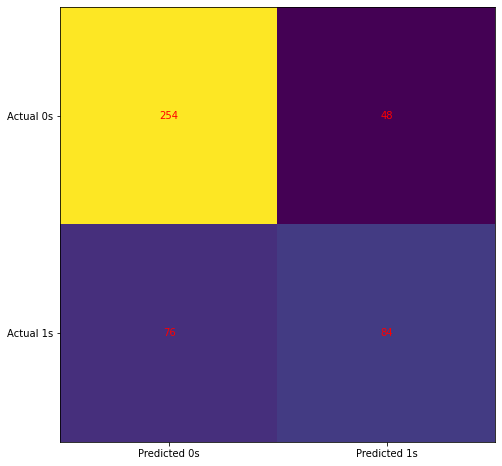

In [861]:
def confussion(cm):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(cm)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
    plt.show()
confussion(cm)

Otra manera de calcular una regresión logistica es con la librería **sklearn** tal como se muestra a continuación.

In [862]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
logisticRegr.predict(X_test[0].reshape(1,-1))
logisticRegr.predict(X_test[0:10])
predictions = logisticRegr.predict(X_test)
error = y_test - predictions
## Utilice el método de score para obtener la precisión del modelo
score = logisticRegr.score(X_test, y_test)
parametros=logisticRegr.get_params(deep=False)
print(score)

0.7229437229437229


### Rgresión logística aplicada a clasificación de regiones de consumo de electricidad.



#https://www-datasklr-com.translate.goog/select-classification-methods/linear-and-quadratic-discriminant-analysis?_x_tr_sl=en&_x_tr_tl=es&_x_tr_hl=en-US&_x_tr_pto=wapp

In [863]:
## Procesamos datos
df = pd.read_csv('r_Regiones_100s_train.csv')
df=df.assign(const=1)
dfy = df['Clase'] 
dfx = df[['GenTer','GenHid','GenRE','GenNP','Demanda','Perdidas','PrecioMarginal']]  ## Predictors
X = dfx.to_numpy() 
## X = sm.add_constant(X) ## para agregar una constante en uno
y = dfy.to_numpy()

In [864]:
## Crea conjuntos de datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.70, random_state = 5)

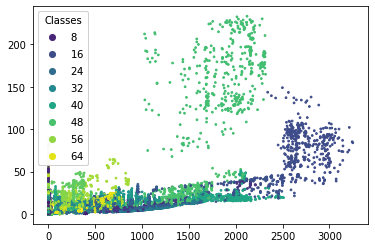

In [865]:
fig, ax = plt.subplots()
scatter = ax.scatter(X_train[:,0], X_train[:,5], c=y_train, s=3)
legend1 = ax.legend(*scatter.legend_elements(),loc="upper left",title="Classes")

ax.add_artist(legend1)
plt.show()

In [866]:
LDA_model_default = LinearDiscriminantAnalysis()
LDA_model_default.fit(X_test, y_test)
y_pred_LDA_default = LDA_model_default.predict(X_test)
print(y_pred_LDA_default)
score = LDA_model_default.score(X_test, y_test)
params = LDA_model_default.get_params(deep=False)
print(score)

[44 44 29 ... 65  8 16]
0.576048329779673


In [867]:
QDA_model_default = QuadraticDiscriminantAnalysis()
QDA_model_default.fit(X_test, y_test)
y_pred_QDA_default = QDA_model_default.predict(X_test)
print(y_pred_QDA_default)
score = QDA_model_default.score(X_test, y_test)
params = QDA_model_default.get_params(deep=False)
print(score)

[1 1 1 ... 1 1 1]
0.014895759298744373


## Pruebas con datos clasificados en en clusters
Haremos algunas pruebas con datos de ejemplo en 2D para predecir un conjunto de datos provenientes de tres clases usando LDA Y QDA.

In [868]:
## Leemos los datos 
df = pd.read_csv('clusters.csv')
dfy = df['y'] 
dfx = df[['X1','X2']]
#dfx = dfx.assign(const=1)

scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
dfx = pd.DataFrame(scaler.fit_transform(dfx), columns=dfx.columns)

X = dfx.to_numpy()
#X = sm.add_constant(X) ## para agregar una constante en uno
y = dfy.to_numpy()

In [869]:
## Crea conjuntos de datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.50, random_state = 5)

In [870]:
LDA_model_default = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
LDA_model_default.fit(X_test, y_test)
y_pred_LDA_default = LDA_model_default.predict(X_test)
score = LDA_model_default.score(X_test, y_test)
parametros = LDA_model_default.get_params(deep=False)
print(score)
print(LDA_model_default)

0.9906666666666667
LinearDiscriminantAnalysis(store_covariance=True)


In [871]:
def plot_ellipse2(mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(mean,2*v[0]**0.5,2*v[1]**0.5,180 + angle,
                              facecolor=color,edgecolor="black",linewidth=2,)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.2)
    return ell

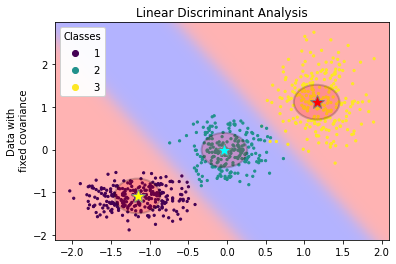

In [872]:
fig, ax = plt.subplots()
scatter = ax.scatter(X_train[:,0], X_train[:,1], c=y_train, s=5)
legend1 = ax.legend(*scatter.legend_elements(),loc="upper left",title="Classes")

ax.add_artist(legend1)

plt.title("Linear Discriminant Analysis")
plt.ylabel("Data with\n fixed covariance")

# means
plt.plot(
    LDA_model_default.means_[0][0], LDA_model_default.means_[0][1],
     "*", color="yellow", markersize=15, markeredgecolor="grey",)
plt.plot(
    LDA_model_default.means_[1][0], LDA_model_default.means_[1][1],
    "*", color="cyan", markersize=15, markeredgecolor="grey",)
plt.plot(
    LDA_model_default.means_[2][0], LDA_model_default.means_[2][1],
    "*", color="red", markersize=15, markeredgecolor="grey",)

# class 0 and 1 : areas
nx, ny = 800, 400
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
Z = LDA_model_default.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:, 1].reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap="red_blue_classes", norm=colors.Normalize(0.0, 1.0), zorder=0)

ell=plot_ellipse2(LDA_model_default.means_[0],LDA_model_default.covariance_,"red")
ax.add_patch(ell)
ell=plot_ellipse2(LDA_model_default.means_[1],LDA_model_default.covariance_,"red")
ax.add_patch(ell)
ell=plot_ellipse2(LDA_model_default.means_[2],LDA_model_default.covariance_,"red")
ax.add_patch(ell)

plt.show()

In [873]:
QDA_model_default = QuadraticDiscriminantAnalysis()
QDA_model_default.fit(X_test, y_test)
y_pred_QDA_default = QDA_model_default.predict(X_test)
y_pred_QDA_default.tofile('predictionQDA.csv',sep=',')
score = QDA_model_default.score(X_test, y_test)
parametros = QDA_model_default.get_params(deep=False)
print(score)

0.9933333333333333


In [874]:
def plot_ellipse(ax, mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(mean,2*v[0]**0.5,2*v[1]**0.5,180 + angle,
                              facecolor=color,edgecolor="black",linewidth=2,)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.2)
    splot.add_artist(ell)
    splot.set_xticks(())
    splot.set_yticks(())

AttributeError: ignored

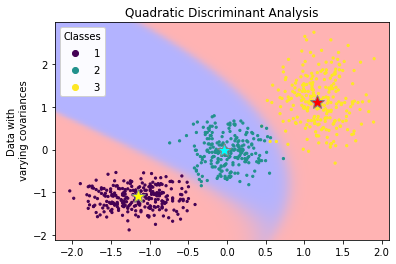

In [875]:
fig, ax = plt.subplots()
scatter = ax.scatter(X_train[:,0], X_train[:,1], c=y_train, s=5)
legend1 = ax.legend(*scatter.legend_elements(),loc="upper left",title="Classes")

ax.add_artist(legend1)

plt.title("Quadratic Discriminant Analysis")
plt.ylabel("Data with\n varying covariances")

# means
plt.plot(QDA_model_default.means_[0][0], QDA_model_default.means_[0][1],
     "*", color="yellow", markersize=15, markeredgecolor="grey",)
plt.plot(QDA_model_default.means_[1][0], QDA_model_default.means_[1][1],
    "*", color="cyan", markersize=15, markeredgecolor="grey",)
plt.plot(QDA_model_default.means_[2][0], QDA_model_default.means_[2][1],
    "*", color="red", markersize=15, markeredgecolor="grey",)

# class 0 and 1 : areas
nx, ny = 800, 400
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
Z = QDA_model_default.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:, 1].reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap="red_blue_classes", norm=colors.Normalize(0.0, 1.0), zorder=0)

#Elipse
mean = QDA_model_default.means_[0]
cov  = QDA_model_default.covariance_
color = "red"
v, w = linalg.eigh(cov)
u = w[0] / linalg.norm(w[0])
angle = np.arctan(u[1] / u[0])
angle = 180 * angle / np.pi  # convert to degrees
# filled Gaussian at 2 standard deviation
ell = mpl.patches.Ellipse(mean,2*v[0]**0.5,2*v[1]**0.5,180 + angle,
                              facecolor=color,edgecolor="black",linewidth=2,)
#ell.set_clip_box(splot.bbox)
ell.set_alpha(0.2)
plt.add_artist(ell)
plt.set_xticks(())
plt.set_yticks(())
plt.show()

**bold text**

In [ ]:
cmap = colors.LinearSegmentedColormap(
    "red_blue_classes",
    {"red": [(0, 1, 1), (1, 0.7, 0.7)],"green": [(0, 0.7, 0.7), (1, 0.7, 0.7)],"blue": [(0, 0.7, 0.7), (1, 1, 1)],},)
plt.cm.register_cmap(cmap=cmap)

# Plot functions
def plot_data(lda, X, y, y_pred, fig_index):
    splot = plt.subplot(2, 2, fig_index)
    if fig_index == 1:
        plt.title("Linear Discriminant Analysis")
        plt.ylabel("Data with\n fixed covariance")
    elif fig_index == 2:
        plt.title("Quadratic Discriminant Analysis")
    elif fig_index == 3:
        plt.ylabel("Data with\n varying covariances")

    tp = y == y_pred  # True Positive
    tp0, tp1 = tp[y == 0], tp[y == 1]
    X0, X1 = X[y == 0], X[y == 1]
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]

    # class 0: dots
    plt.scatter(X0_tp[:, 0], X0_tp[:, 1], marker=".", color="red")
    plt.scatter(X0_fp[:, 0], X0_fp[:, 1], marker="x", s=20, color="#990000") # dark red

    # class 1: dots
    plt.scatter(X1_tp[:, 0], X1_tp[:, 1], marker=".", color="blue")
    plt.scatter(X1_fp[:, 0], X1_fp[:, 1], marker="x", s=20, color="#000099") # dark blue

    # class 0 and 1 : areas
    nx, ny = 800, 400
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap="red_blue_classes", norm=colors.Normalize(0.0, 1.0), zorder=0)
    plt.contour(xx, yy, Z, [0.5], linewidths=2.0, colors="white")

    # means
    plt.plot(
        lda.means_[0][0],
        lda.means_[0][1],
        "*",
        color="yellow",
        markersize=15,
        markeredgecolor="grey",
    )
    plt.plot(
        lda.means_[1][0],
        lda.means_[1][1],
        "*",
        color="yellow",
        markersize=15,
        markeredgecolor="grey",
    )
    return splot

def plot_ellipse(splot, mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(mean,2*v[0]**0.5,2*v[1]**0.5,180 + angle,
                              facecolor=color,edgecolor="black",linewidth=2,)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.2)
    splot.add_artist(ell)
    splot.set_xticks(())
    splot.set_yticks(())

def plot_lda_cov(lda, splot):
    plot_ellipse(splot, lda.means_[0], lda.covariance_, "red")
    plot_ellipse(splot, lda.means_[1], lda.covariance_, "blue")

def plot_qda_cov(qda, splot):
    plot_ellipse(splot, qda.means_[0], qda.covariance_[0], "red")
    plot_ellipse(splot, qda.means_[1], qda.covariance_[1], "blue")

def dataset_fixed_cov():
    ## 2 muestras gaussianas con la misma matriz de covarianza
    return X_train, y_train

def dataset_cov():
    ## 2 muestras de gaussianas con diferentes matrices de covarianza
    return  X_train, y_train

In [ ]:
plt.figure(figsize=(10, 8), facecolor="white")
plt.suptitle(
    "Linear Discriminant Analysis vs Quadratic Discriminant Analysis",y=0.98,fontsize=15,
    )
for i, (X, y) in enumerate([dataset_fixed_cov(), dataset_cov()]):
    # Linear Discriminant Analysis
    lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
    y_pred = lda.fit(X, y).predict(X)
    splot = plot_data(lda, X, y, y_pred, fig_index=2 * i + 1)
    plot_lda_cov(lda, splot)
    plt.axis("tight")

    # Quadratic Discriminant Analysis
    qda = QuadraticDiscriminantAnalysis(store_covariance=True)
    y_pred = qda.fit(X, y).predict(X)
    splot = plot_data(qda, X, y, y_pred, fig_index=2 * i + 2)
    plot_qda_cov(qda, splot)
    plt.axis("tight")
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

## Ligas relacionadas

1. [Ejemplo de grafica de LDA Y QDA de scikit-learn.org ](https://scikit-learn.org/stable/auto_examples/classification/plot_lda_qda.html)  
2.  [Análisis Discriminante Lineal y Cuadrático de scikit-learn.org](https://scikit-learn.org/stable/modules/lda_qda.html) 
3. [Análisis Discriminante Lineal y Cuadrático de datasklr.com](https://www.datasklr.com/select-classification-methods/linear-and-quadratic-discriminant-analysis)
4. [Regresión logística usando Python (scikit-learn)
](https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a)

